In [9]:
import os
import torch

#计算每一张图片的值
def calculate_each_image(gt_path, sr_path):
    gt_matrix = torch.load(gt_path)
    # # 将 gt_matrix 移动到主机内存上
    # gt_matrix = gt_matrix.cpu()
    # # 如果 gt_matrix 是四维张量，将其转换为二维数组
    # gt_matrix = gt_matrix.squeeze()

    
    # # 使用 Matplotlib 绘制图像
    # plt.imshow(gt_matrix.numpy(), cmap='gray')  # 使用灰度色彩图显示图像
    # plt.axis('off')  # 关闭坐标轴
    # plt.show()
    
    sr_matrix = torch.load(sr_path)
    
    sr_matrix = sr_matrix.to(gt_matrix.device)
    
    sr_binary = torch.where(sr_matrix >= 0.5, torch.tensor(1, device=sr_matrix.device), torch.tensor(0, device=sr_matrix.device))
    gt_binary = torch.where(gt_matrix > 0, torch.tensor(1, device=gt_matrix.device), torch.tensor(0, device=gt_matrix.device))

    
    tp = torch.sum((gt_binary == 1) & (sr_binary == 1)).item()
    fp = torch.sum((gt_binary == 0) & (sr_binary == 1)).item()
    tn = torch.sum((gt_binary == 0) & (sr_binary == 0)).item()
    fn = torch.sum((gt_binary == 1) & (sr_binary == 0)).item()
    
    # print("TP:", tp)
    # print("FP:", fp)
    # print("TN:", tn)
    # print("FN:", fn)
    
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, sensitivity, specificity, sr_matrix.detach().cpu().numpy().flatten(), gt_binary.detach().cpu().numpy().flatten()



def calculate_model_performance(model='U_Net',pre='pre',loss='Dice'):
    
    #遍历所有测试结果的图片
    
    all_gt = []
    all_sr = []
    accuracy_list = []
    sensitivity_list = []
    specificity_list = []
    auc_list = []
    
    for i in range(1, 32):
    #for i in range(1, 2):
        gt_path = f"./result/{pre}_{model}_{loss}/{model}_test_{i}_GT.bin"
        sr_path = f"./result/{pre}_{model}_{loss}/{model}_test_{i}_SR.bin"
          
        accuracy, sensitivity, specificity, sr_matrix, gt_matrix = calculate_each_image(gt_path, sr_path)
        
        
        accuracy_list.append(accuracy)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        
        # 计算 AUC
        auc = roc_auc_score(gt_matrix, sr_matrix)
        auc_list.append(auc)

        
        all_gt.append(gt_matrix)
        all_sr.append(sr_matrix)
    
    # 假设 all_gt 是包含 33 个列表的列表
    all_gt_flat = [item for sublist in all_gt for item in sublist]
    
    # 将列表转换为 numpy 数组，并拉平
    all_gt_flat_np = np.array(all_gt_flat).flatten()
    
    # 假设 all_sr 是包含 33 个列表的列表
    all_sr_flat = [item for sublist in all_sr for item in sublist]
    
    # 将列表转换为 numpy 数组，并拉平
    all_sr_flat_np = np.array(all_sr_flat).flatten()
    
    
    avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    avg_sensitivity = sum(sensitivity_list) / len(sensitivity_list)
    avg_specificity = sum(specificity_list) / len(specificity_list)
    avg_auc = sum(auc_list) / len(auc_list)
    result = {}
    result['avg_accuracy'] = avg_accuracy
    result['avg_sensitivity'] = avg_sensitivity
    result['avg_specificity'] = avg_specificity
    result['avg_auc'] = avg_auc
    print(result)
    return result,all_gt_flat_np,all_sr_flat_np


pre_type = ['pre', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5', 'pre6', 'pre7', 'pre14', 'pre16', 'pre25', 'pre27']
model_type = ['U_Net', 'R2U_Net', 'AttU_Net', 'R2AttU_Net']
loss_type = ['Dice', 'BCE', 'mixed']

results = {}

for pre in pre_type:
    for model in model_type:
        for loss in loss_type:
            try:
                # 假设calculate_model_performance返回三个值：result, all_gt_flat_np, all_sr_flat_np
                result, all_gt_flat_np, all_sr_flat_np = calculate_model_performance(model, pre, loss)
                # 将结果保存到字典中
                key_prefix = f"saved_{pre}_{model}_{loss}"
                results[key_prefix] = {'result': result, 'all_gt_flat_np': all_gt_flat_np, 'all_sr_flat_np': all_sr_flat_np}

            except:
                break
            

{'avg_accuracy': 0.9988020927675308, 'avg_sensitivity': 0.8397926676662087, 'avg_specificity': 0.9988529827546834, 'avg_auc': 0.9140832298367288}


In [6]:
results

{'saved_pre_U_Net_Dice': {'result': {'avg_accuracy': 0.9988020927675308,
   'avg_sensitivity': 0.8397926676662087,
   'avg_specificity': 0.9988529827546834,
   'avg_auc': 0.9140832298367288},
  'all_gt_flat_np': array([0, 0, 0, ..., 0, 0, 0]),
  'all_sr_flat_np': array([3.9390513e-10, 6.2237739e-08, 8.9793616e-08, ..., 1.3287567e-07,
         8.4365041e-08, 6.0996769e-10], dtype=float32)}}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


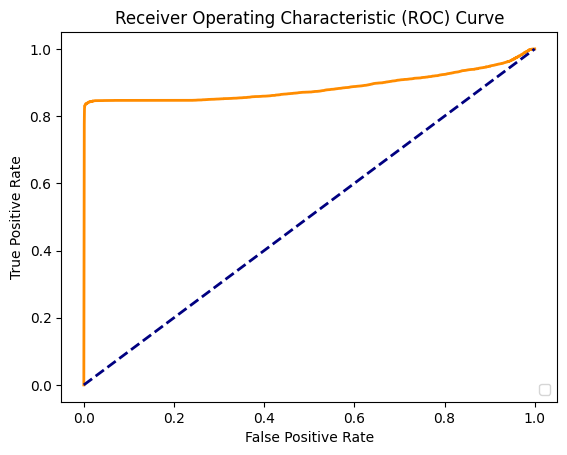

In [8]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

all_gt_flat_np=results['saved_pre_U_Net_Dice']['all_gt_flat_np']
all_sr_flat_np=results['saved_pre_U_Net_Dice']['all_sr_flat_np']
# 计算 ROC 曲线的真阳性率（tpr）、假阳性率（fpr）和阈值（thresholds）
fpr, tpr, thresholds = roc_curve(all_gt_flat_np, all_sr_flat_np)


# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



